# Introduction

This notebook aims at discovering Convolutional Neural Network. We will see the theory behind it, and an implementation in Pytorch for hand-digits classification on MNIST dataset. 

In [ ]:
! pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 127.2 MB 39 kB/s 
     |████████████████████████████████| 5.4 MB 34.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0+cpu which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0+cpu which is incompatible.


In [ ]:
#Loading Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Pytorch's torchvision module conveniently packages the MNIST dataset into a `torchvision.datasets.MNIST` class for us. We simply need to specify the dataset split (train/test) and the transformations (augmentations we want to apply on each image).

We wrap the dataset objects via Pytorch's `torch.utils.data.DataLoader` class to get dataloaders which will return entire batches of samples, and also optionally shuffle the dataset internally.

In [ ]:
# training time transformations
transforms_train = transforms.Compose([
    # problem specific data augmentations can be applied here
    transforms.ToTensor(),
    #output[channel] = (input[channel] - mean[channel]) / std[channel] Mean and Std is passed below
    #mean, std = img.mean([1,2]), img.std([1,2])
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset_train = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms_train
)
dataloader_train = DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
)

transforms_test =transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])
dataset_test = datasets.MNIST(
    root='./data',
    train=False,
    download=False,
    transform=transforms_test
)
dataloader_test = DataLoader(
    dataset_test,
    batch_size=128,
    shuffle=False,
)

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


Convolutional Neural Networks
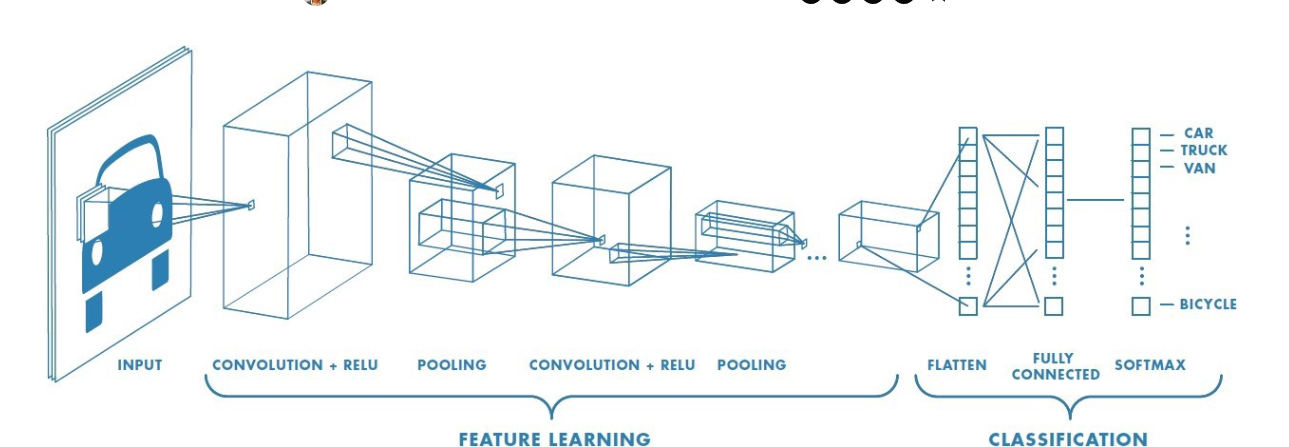



The architecture of a ConvNet is analogous to that of the connectivity pattern of Neurons in the Human Brain and was inspired by the organization of the Visual Cortex.
They are a) Efficient than the feed forward networks which operate pixel-wise b)They capture temporal and spatial dependencies through application of appropriate filters.


---


Convolution Filter:
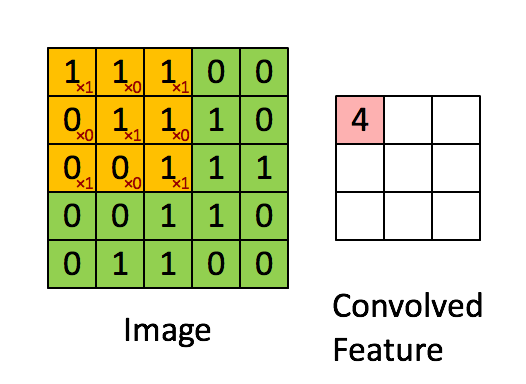

Convolution for 3 channels:
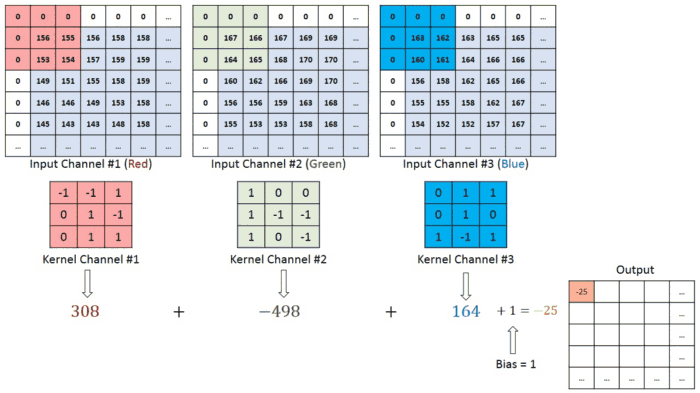

Stride and Padding:
Stride denotes how many steps we are moving in each steps in convolution.By default it is one.
Padding is a process of adding zeros to the input matrix symmetrically. 
Dimension of output layer after applying convolution (N x N) * (F x F) = (N-F+1)x(N-F+1) (Without Stride and Padding)

Layers in CNN
There are five different layers in CNN
Input layer
Convo layer (Convo + ReLU)
Pooling layer
Fully connected(FC) layer
Softmax/logistic layer
Output layer
Relu Layer: The ReLU layer applies the function f(x) = max(0, x)


Pooling Layer:

---


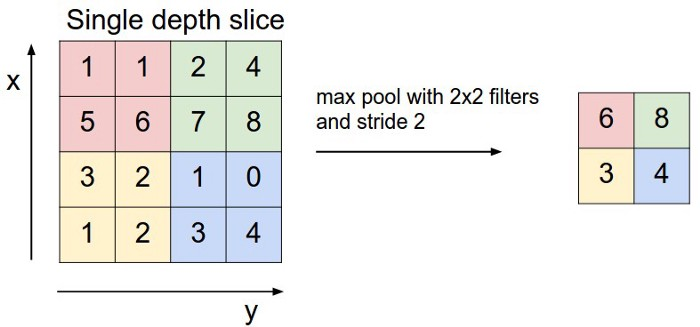

Dropout Layer:

---


The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.

We now create a CNN class, which has to be a subclass of `torch.nn.Module` and have its own `__init__` and `forward` functions. 

We choose a simple architecture with `3 convolutional blocks` followed by `2 fully connected blocks`. 

---
Defining layer Dimensions:

https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1) #32 filters of size 5x5 with stride=1, no padding. No of input channels =1 since we use grey scale
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # BLOCK 1: CONV + RELU
        x = F.relu(self.conv1(x))
        # BLOCK 2: CONV + MAXPOOL + RELU + DROPOUT
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        # BLOCK 3: CONV + MAXPOOL + RELU + DROPOUT
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        # FLATTEN
        x = x.flatten(start_dim=1)
        # x = x.view(-1, 3*3*64)
        # BLOCK 4: FC + RELU + DROPOUT
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # BLOCK 5: FC + LOG SOFTMAX
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

model = CNN()
print(model)

it = iter(dataloader_train)
X_batch, y_batch = next(it)
print(model(X_batch).shape)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([128, 10])


Now we create some utility functions to help with the training and evaluation process. Most of this is boilerplate code that can be reused with simple changes.

For training, we iterate over the datalaoder to get batches, and for eah batch we do the following: 

- move each batch onto the specified device
- perform a forward pass through the model to get the outputs
- compute the loss based on the outputs and targets
- compute the gradients via backpropagation
- update the weights via the optimizer

In [ ]:
def train(model, device, data_loader, optimizer, criterion, epoch):
    model.train()
    loss_train = 0
    num_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        prediction = output.argmax(dim=1)
        num_correct += prediction.eq(target).sum().item()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}\tAccuracy: {:.0f}%'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item(),
                100. * num_correct / (len(data) * (batch_idx + 1))))
    loss_train /= len(data_loader)
    accuracy = num_correct / len(data_loader.dataset)
    return loss_train, accuracy
    

def test(model, device, data_loader, criterion):
    model.eval()
    loss_test = 0
    num_correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            loss_test += loss.item()  # sum up batch loss
            prediction = output.argmax(dim=1)
            num_correct += prediction.eq(target).sum().item()
    loss_test /= len(data_loader)
    accuracy = num_correct / len(data_loader.dataset)
    return loss_train, accuracy

Now we put it all together:

- Create the model
- Set up the loss function (cross entropy)
- Add an optimizer (in this case, Adam)
- [Optional] Have a learning rate scheduler
We base our experiment on the principle of step decay. Here, we reduce the learning rate by a constant factor every few epochs. 

In [ ]:
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) #, betas=(0.9,0.999))
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)
epochs = 3

for epoch in range(1, epochs + 1):
    loss_train, acc_train = train(model, device, dataloader_train, optimizer, criterion, epoch)
    print('Epoch {} Train: Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
        epoch, loss_train, 100. * acc_train))
    loss_test, acc_test = test(model, device, dataloader_test, criterion)
    print('Epoch {} Test : Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
        epoch, loss_test, 100. * acc_test))
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.3260	Accuracy: 9%
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.4446	Accuracy: 59%
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.3890	Accuracy: 73%
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.2513	Accuracy: 80%
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.1470	Accuracy: 83%
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.1801	Accuracy: 85%
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.1934	Accuracy: 87%
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.0694	Accuracy: 88%
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.0664	Accuracy: 89%
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.0915	Accuracy: 90%
Epoch 1 Train: Loss: 0.3042, Accuracy: 90.167%

Epoch 1 Test : Loss: 0.3042, Accuracy: 98.590%

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.1197	Accuracy: 97%
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.1471	Accuracy: 97%
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.1036	Accuracy: 97%
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.1457	Accuracy: 97%
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.1227	A

In [ ]:
loss_test, acc_test = test(model, device, dataloader_test, criterion)
print('Epoch {} Test : Loss: {:.4f}, Accuracy: {:.3f}%\n'.format(
    epoch, loss_test, 100. * acc_test))

Epoch 1 Test : Loss: 0.2988, Accuracy: 98.570%

